# 🤔 Decision Analysis - Project 3: Preference learning
* Zuzanna Gawrysiak: 148255
* Agata Żywot: 148258

Data source: https://en.cs.uni-paderborn.de/is/research/research-projects/software/monotone-learning-datasets (mammographic)

<br><br><br>
**TODO**🥴🥴🥴🥴
- [x] Put functions into modules (można mu wysłać linka do repo)
- [x] Describe the data set including the criteria descriptions
- [x] One interpretable ML model (**XGBoost** or rankSVM or Logistic Regression) -> Zuza
- [x] One interpretable neural MCDA method (ANN-Ch-Constr. or **ANN UTADIS**) -> Agata (3 examples todo)
- [ ] Neural network with a few layers with nonlinear activation functions -> Agata (mogę dokończyć bo jestem late to the party)


Double check (for each model):
- report Accuracy, F1 and AUC
- model visualizations
- All presented values should be rounded to a maximum of 4 decimal places
- LANIE WODY:
  -  Based on the parameters obtained, can we say something about the user’s
preferences? Are there any criteria that have no effect, or have a decisive
influence. Whether there are any preference thresholds? Are there any
evaluations on criteria that are indifference in terms of preferences?
- 3 alternatives + change
- interpretation using Global Surrogate, Partial Dependence, Plot Permutation Feature Importance etc

## Import necessary libraries

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import xgboost as xgb
from xgboost import plot_tree
import pandas as pd
import matplotlib.pyplot as plt
import shap
import dalex as dx
import torch
from tqdm.notebook import tqdm as tqdm

from src.neural_net import data_loader, SimpleNN, train
from src.xgboost import create_xgb_model
from src.interpret import add_measures, score_model, shap_tree_explainer, plot_marginal_values_ann_utadis, plot_measures
from src.helpers import CreateDataLoader, Train, BCELoss
from src.nb_UTA import *

## Data
Note - the `mammographic` dataset used is not described in terms of the meaning of a particular criterio, hence we will use `Criterion #1`, `Criterion #2` etc.

In [4]:
DATA_PATH = "data/mammographic.csv"
data = pd.read_csv(DATA_PATH, header=None)
records = len(data)
data = data.drop_duplicates()
print(f'Number of duplicate records: {records-len(data)}')

Number of duplicate records: 266


In [5]:
columns_dict = {0: 'Criterion #1', 1: 'Criterion #2', 2: 'Criterion #3', 3: 'Criterion #4', 4: 'Criterion #5', 5:'Target'}
data.rename(columns=columns_dict, inplace=True)
data.describe()

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5,Target
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,0.079884,0.485088,0.615248,0.471631,0.626478,0.496454
std,0.041198,0.193954,0.397242,0.381164,0.138930,0.500431
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.072727,0.346154,0.333333,0.000000,0.666667,0.000000
50%,0.072727,0.500000,0.666667,0.500000,0.666667,0.000000
75%,0.090909,0.628205,1.000000,0.750000,0.666667,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


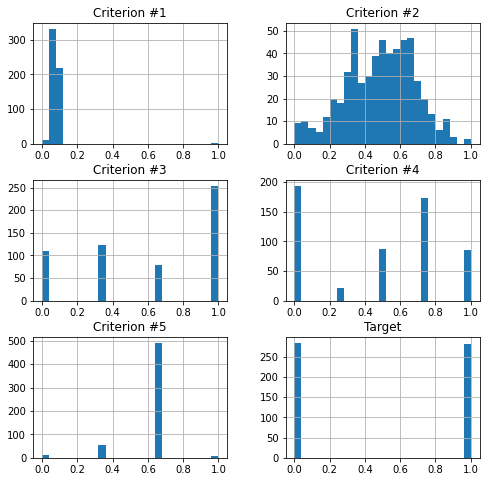

In [6]:
data.hist(bins=25, figsize=(8, 8));

In [7]:
data.quantile([0.99])

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5,Target
0.99,0.109091,0.871795,1.0,1.0,1.0,1.0


There are no missing values, one can instatnly notice the dataset is balanced (criterion 5 treated as target). <br>However, it can be seen that the criterion 0 is highly imbalanced and almost all examples oscilates between 0.0-0.1 (quantiles).

In [8]:
criteria_nr = 5
data_input = data.iloc[:, :criteria_nr]
data_target = data['Target']

display(data_input.head())
display(data_target.head())

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5
0,0.090909,0.628205,0.666667,1.00,0.666667
1,0.090909,0.512821,1.000000,1.00,0.666667
2,0.072727,0.128205,0.000000,0.00,0.666667
3,0.090909,0.500000,0.000000,1.00,0.666667
4,0.090909,0.743590,0.000000,0.75,0.666667


0    1.0
1    1.0
2    0.0
3    1.0
4    1.0
Name: Target, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target, test_size=0.2, random_state=1234
)

## Experiments

In [10]:
MEASURES = dict() # used to store measures for each model

### ML model - XGBoost

In [11]:
model_xgboost = create_xgb_model(criteria_nr)
model_xgboost.fit(X_train, y_train);

In [12]:
y_pred = model_xgboost.predict(X_train)

accuracy, f1, auc = score_model(y_train, y_pred)
print(f"Train\nAccuracy: {accuracy}\nF1: {f1}\nAUC: {auc}")
MEASURES = add_measures(MEASURES, (accuracy, f1, auc), 'XGBoost', 'train')

Train
Accuracy: 0.7982
F1: 0.7859
AUC: 0.7974


In [13]:
y_pred = model_xgboost.predict(X_test)

accuracy, f1, auc = score_model(y_test, y_pred)
print(f"Test\nAccuracy: {accuracy}\nF1: {f1}\nAUC: {auc}")
MEASURES = add_measures(MEASURES, (accuracy, f1, auc), 'XGBoost', 'test')

Test
Accuracy: 0.8319
F1: 0.8224
AUC: 0.8358


#### Interpreting the model

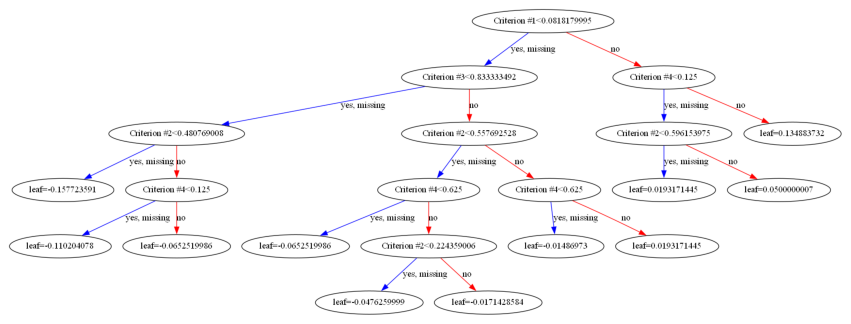

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(model_xgboost, ax=ax, num_trees=0);

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


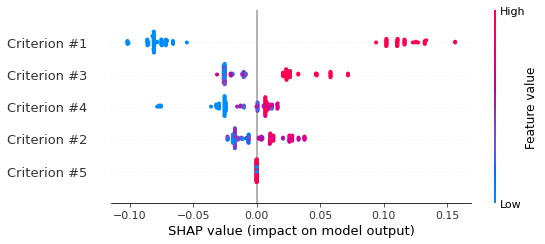

In [15]:
shap_explainer, shap_values = shap_tree_explainer(model_xgboost, X_test, y_pred)

The plot shows the `Criterion #1` (the imbalanced one) has the greatest impact on the final decision, `Criterion #4`'s impact is, on the other hand, negligible.    

In [16]:
dalex_explainer = dx.Explainer(model_xgboost, X_train, y_train, label="XGBoost")

Preparation of a new explainer is initiated

  -> data              : 451 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 451 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost
  -> predict function  : <function yhat_proba_default at 0x0000022CAC9E1F30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.461, mean = 0.498, max = 0.534
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.534, mean = -0.00791, max = 0.539
  -> model_info        : package xgboost

A new explainer has been created!


In [17]:
fi = dalex_explainer.model_parts()
fi.plot()

Feature importance is also consistent with Dalex approach (how much the model would worsen if a particular feature was removed - more precisely shuffled here).

#### Taking 3 alternatives and veryfing what the minimum change to a single criterion should be done to change classification

In [18]:
# NOTE: shouldn't we use eg. some kind of 0/1 representatives + one random sample?
SAMPLES_3 = X_test.iloc[:3].copy()
SAMPLES_3

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5
682,0.072727,0.628205,0.0,0.75,0.666667
266,0.072727,0.346154,0.0,0.25,0.666667
231,0.072727,0.628205,1.0,0.00,0.666667


In [19]:
y_pred = model_xgboost.predict(SAMPLES_3)
y_pred

array([0, 0, 0])

In [20]:
dalex_explainer.predict_profile(SAMPLES_3).plot()

Calculating ceteris paribus: 100%|██████████| 5/5 [00:00<00:00, 147.46it/s]


For all the alternatives the minimal value to change classifications seems to exist for `Criterion #1`. Note that for `Criterion #2` and `Criterion #5` (no surprise in this case) there are no change that would change the prediction

In [21]:
# changing the values to verify theoretical predictions
samples_3 = SAMPLES_3.copy()
samples_3['Criterion #1'] = 0.09
samples_3

,Criterion #1,Criterion #2,Criterion #3,Criterion #4,Criterion #5
682,0.09,0.628205,0.0,0.75,0.666667
266,0.09,0.346154,0.0,0.25,0.666667
231,0.09,0.628205,1.0,0.00,0.666667


In [22]:
y_pred = model_xgboost.predict(samples_3)
y_pred

array([1, 1, 1])

The results agree with theoretical predictions.

In [23]:
# explaining predictions for each object
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[0,:], samples_3.iloc[0], link="logit")

In [24]:
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[0,:], samples_3.iloc[1], link="logit")

In [25]:
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[0,:], samples_3.iloc[2], link="logit")

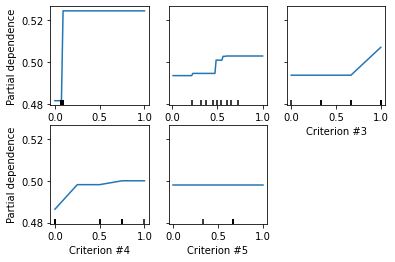

In [26]:
PartialDependenceDisplay.from_estimator(model_xgboost, X_train, [0, 1, 2, 3, 4])
# NOTE: maybe this one?
# partial dependency plot - avg output of the model for different values of the feature
# dalex_explainer.model_profile().plot()

In [27]:
result = permutation_importance(model_xgboost, X_train, y_train, n_repeats=10, random_state=0)
result.importances_mean

array([0.25210643, 0.02682927, 0.01108647, 0.01441242, 0.        ])

One may notice that the most important feature for the model is `Criterion #1`, which has a feature importance score of approx. 0.2521.<br>The remaining features have much lower importance scores ranging from 0.0 to ~0.02683.

### Neural MCDA - ANN-UTADIS

In [46]:
data_input_nn = data_input.values.reshape(-1, 1, criteria_nr)

X_train, X_test, y_train, y_test = train_test_split(
    data_input_nn, data_target.values, test_size=0.2, random_state=1234
)

In [47]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [48]:
torch.manual_seed(1234) #set seed for reproducibility

ANN_UTA_PATH = "models/uta.pt2"
uta = Uta(criteria_nr, 30)
model_ann_uta = NormLayer(uta, criteria_nr)

acc, acc_test, auc, auc_test, f1, f1_test = Train(model_ann_uta, train_dataloader, test_dataloader, ANN_UTA_PATH)
print("TRAIN:")
print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (auc * 100.0))
print("F1 train: \t%.2f%%" % (f1 * 100.0))
print("TEST:")
print("Accuracy test:\t%.2f%%" % (acc_test * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))
print("F1 test: \t%.2f%%" % (f1_test * 100.0))

100%|██████████| 200/200 [00:04<00:00, 40.12it/s]

TRAIN:
Accuracy train:	74.94%
AUC train: 	78.57%
F1 train: 	72.77%
TEST:
Accuracy test:	59.29%
AUC test: 	84.82%
F1 test: 	69.74%


In [31]:
MEASURES = add_measures(MEASURES, (acc, f1, auc), 'ANN-UTA', 'train')
MEASURES = add_measures(MEASURES, (acc_test, f1_test, auc_test), 'ANN-UTA', 'test')

In [32]:
# load a model from the path
# checkpoint = torch.load(ANN_UTA_PATH)
# model_ann_uta.load_state_dict(checkpoint["model_state_dict"])

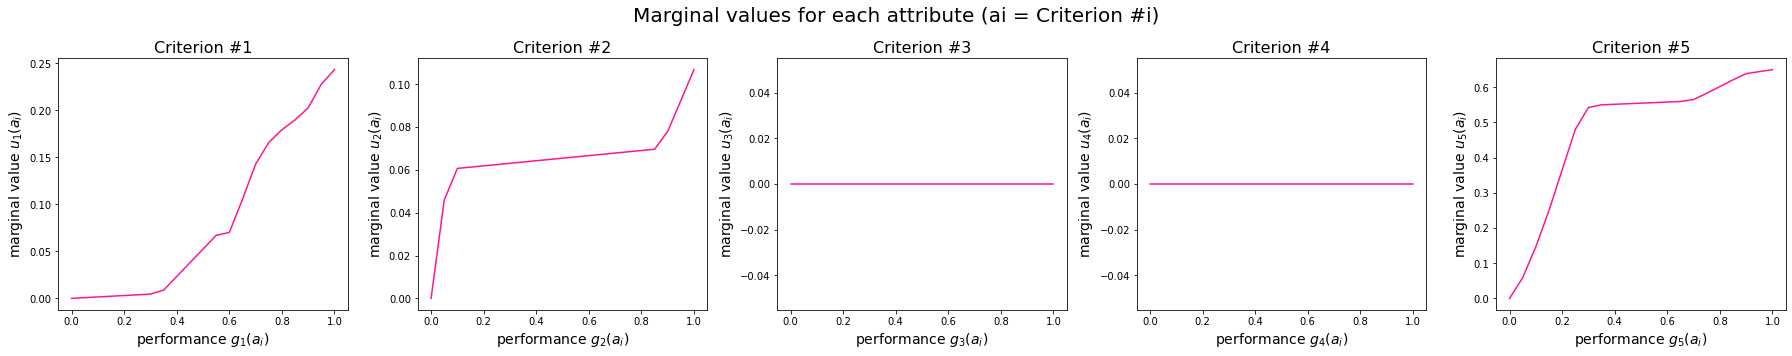

In [33]:
plot_marginal_values_ann_utadis(model_ann_uta, criteria_nr)

One can immediately notice that in this case `Criterion #5` has the greatest marginal value (which is the opposite compared to the XGBoost where this criterion had no influence).

#### Taking 3 alternatives and veryfing what the minimum change to a single criterion should be done to change classification

In [34]:
indices = [18, 37, 105]
SAMPLES_3 = X_test[indices].copy()
SAMPLES_3

array([[[0.072727, 0.717949, 0.      , 0.      , 0.      ]],

       [[0.072727, 0.358974, 0.      , 0.      , 0.      ]],

       [[0.072727, 0.051282, 0.333333, 0.      , 0.666667]]])

In [35]:
model_ann_uta.eval()
probs = torch.sigmoid(model_ann_uta(torch.from_numpy(SAMPLES_3)))
probs

tensor([[0.3662],
        [0.3652],
        [0.4976]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [36]:
samples_3 = SAMPLES_3.copy()
samples_3[:, :, 4] = 0.72

In [37]:
res_3 = model_ann_uta(torch.from_numpy(samples_3))
probs = torch.sigmoid(res_3)
probs

tensor([[0.5057],
        [0.5046],
        [0.5004]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

### NN

In [45]:
NN_PATH = "models/simple_nn.pt2"

loss = BCELoss
model_nn = SimpleNN()
acc, acc_test, auc, auc_test, f1, f1_test = Train(model_nn, train_dataloader, test_dataloader, NN_PATH, epoch_nr=200, lr=0.01, loss_function=loss)
print("TRAIN:")
print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (auc * 100.0))
print("F1 train: \t%.2f%%" % (f1 * 100.0))
print("TEST:")
print("Accuracy test:\t%.2f%%" % (acc_test * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))
print("F1 test: \t%.2f%%" % (f1_test * 100.0))

100%|██████████| 400/400 [00:06<00:00, 57.64it/s]

TRAIN:
Accuracy train:	49.00%
AUC train: 	73.42%
F1 train: 	65.77%
TEST:
Accuracy test:	52.21%
AUC test: 	77.78%
F1 test: 	68.60%


In [41]:
MEASURES = add_measures(MEASURES, (acc, f1, auc), 'Simple-NN', 'train')
MEASURES = add_measures(MEASURES, (acc_test, f1_test, auc_test), 'Simple-NN', 'test')

#### Interpreting the model

In [42]:
def f(X):
    X = X.astype(np.float32)
    return model_nn(torch.from_numpy(X)).detach().numpy()

In [43]:
model_nn.eval()
xtest = X_test.copy()
xtest = xtest.astype(np.float32)
xtest = X_test.reshape(113,5)

explainer = shap.KernelExplainer(f, X_test, l1_reg="false")
shap_values = explainer.shap_values(xtest)

shap.force_plot(explainer.expected_value[0], shap_values[0], xtest, link="logit")

Using 113 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/113 [00:00<?, ?it/s]

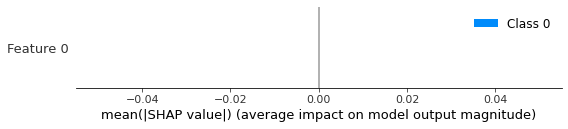

In [44]:
# comment: all shapley values are 0 bc model predicts always the same class (?)

shap.summary_plot(shap_values, X_test)

#### Taking 3 alternatives and veryfing what the minimum change to a single criterion should be done to change classification

In [ ]:
samples_3 = SAMPLES_3.copy()
samples_3 = samples_3.astype(np.float32)
model_nn.eval()
model_nn(torch.from_numpy(samples_3))

tensor([[[0.5000]],

        [[0.5000]],

        [[0.5000]]], grad_fn=<SigmoidBackward0>)

In [ ]:
# ??

NN_PATH = "models/bigger_nn.pt2"

model_nn = BiggerNN()
acc, acc_test, auc, auc_test, f1, f1_test = Train(model_nn, train_dataloader, test_dataloader, ANN_UTA_PATH)

NameError: name 'BiggerNN' is not defined

## Summary

In [ ]:
MEASURES

{'XGBoost': {'train': {'accuracy': 0.7982, 'f1': 0.7859, 'auc': 0.7974},
  'test': {'accuracy': 0.8319, 'f1': 0.8224, 'auc': 0.8358}},
 'ANN-UTA': {'train': {'accuracy': 0.7494, 'f1': 0.7277, 'auc': 0.7857},
  'test': {'accuracy': 0.5929, 'f1': 0.6974, 'auc': 0.8482}},
 'Simple-NN': {'train': {'accuracy': 0.49, 'f1': 0.6577, 'auc': 0.7839},
  'test': {'accuracy': 0.5221, 'f1': 0.686, 'auc': 0.8106}}}

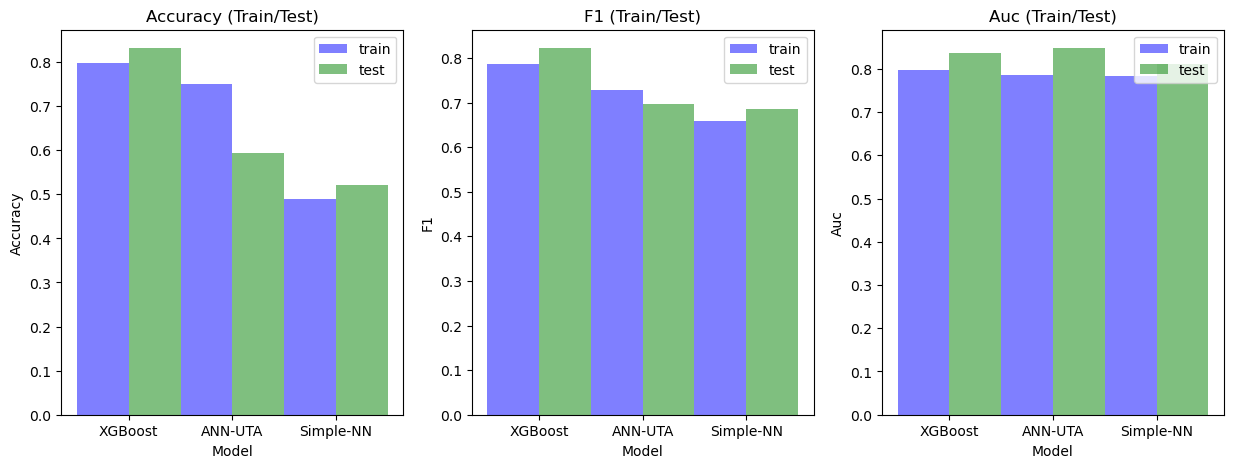

In [ ]:
plot_measures(MEASURES)

TODO: BLABLAAB